This notebook performs the synthesis using our proposed synthesization approach applied to the South Korean COVID-19 data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

In [3]:
train_data

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,1,5,0
1,0.889746,-0.694899,1,5,0
2,0.917482,-0.682299,1,3,0
3,0.916660,-0.682551,1,3,0
4,0.886074,-0.668883,1,3,0
...,...,...,...,...,...
6707,0.881500,-0.925307,1,4,0
6708,-1.728784,1.470871,1,4,0
6709,-1.548071,1.557316,1,4,0
6710,-1.549392,1.555785,1,4,0


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [4]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_sex_,
                 mb_age_,
                 mb_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,["latitude", "longitude"]], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,["latitude", "longitude"]]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,["latitude", "longitude"]])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ####################################################################################################
        
    ########### Code for age CART ##########
    cart_age = DecisionTreeClassifier(min_samples_leaf=mb_age_, random_state=rng)
    
    cart_age.fit(X=train_data.loc[:,["latitude", "longitude", "sex"]], y=train_data.loc[:,"age"])
    
    node_indicators = cart_age.decision_path(train_data.loc[:,["latitude", "longitude", "sex"]]).toarray()
    
    node_outcomes = [train_data.age[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_age.apply(sXs[i].loc[:,["latitude", "longitude", "sex"]])
        
        new_age = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_age[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_age = pd.Series(new_age)
        
        new_age.name = "age"
        
        sXs[i] = pd.concat([sXs[i], new_age], axis=1)
        
    ####################################################################################################
    
    ########### Code for state CART ##########
    
    cart_state = DecisionTreeClassifier(min_samples_leaf=mb_state_, random_state=rng)
    
    cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])
    
    node_indicators = cart_state.decision_path(train_data.loc[:,["latitude", "longitude", "sex", "age"]]).toarray()
    
    node_outcomes = [train_data.state[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_state.apply(sXs[i].loc[:,["latitude", "longitude", "sex", "age"]])
        
        new_state = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_state[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_state = pd.Series(new_state)
        
        new_state.name = "state"
        
        sXs[i] = pd.concat([sXs[i], new_state], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [5]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_sex_, mb_age_, mb_state_):

        pmse_ratios, current_sXs, current_GMM = train_models(train_data=train_data,
                                                             number_synthetic_datasets=number_synthetic_datasets,
                                                             number_gmm_initializations=number_gmm_initializations,
                                                             num_components_=int(num_components_),
                                                             mb_sex_=int(mb_sex_),
                                                             mb_age_=int(mb_age_),
                                                             mb_state_=int(mb_state_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_sex_": (10, 300.99),
            "mb_age_": (10, 300.99),
            "mb_state_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 1         | -0.7169   | 226.2     | 75.89     | 197.0     | 178.5     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 2         | -0.6265   | 225.5     | 219.9     | 95.94     | 110.4     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 3         | -0.2067   | 60.56     | 246.3     | 257.2     | 58.99     |
| 4         | -0.08127  | 79.03     | 143.4     | 76.61     | 48.58     |
| 5         | -1.153    | 296.0     | 295.4     | 223.8     | 88.17     |
| 6         | -0.1109   | 83.26     | 146.7     | 75.51     | 57.2      |
| 7         | -0.2536   | 69.56     | 240.5     | 263.1     | 56.37     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 8         | -1.884    | 10.0      | 178.6     | 118.5     | 10.0      |
| 9         | -0.06527  | 97.56     | 118.2     | 61.35     | 40.71     |
| 10        | -0.007294 | 63.51     | 114.3     | 46.32     | 59.79     |
| 11        | -0.08513  | 73.18     | 89.41     | 84.83     | 69.0      |
| 12        | -0.3871   | 84.56     | 147.9     | 83.65     | 47.33     |
| 13        | -0.03913  | 57.73     | 119.6     | 49.39     | 50.53     |
| 14        | -0.0551   | 74.16     | 131.4     | 61.98     | 58.78     |
| 15        | -0.2241   | 88.38     | 141.1     | 88.14     | 52.34     |
| 16        | -0.1314   | 76.5      | 117.6     | 81.67     | 52.34     |
| 17        | -0.09127  | 66.49     | 81.95     | 40.82     | 56.27     |
| 18        | -0.04653  | 77.4      | 126.6     | 62.49     | 53.99     |
| 19        | -0.2179   | 85.38     | 151.7     | 72.85     | 58.88     |
| 20        | -0.09293  | 75.98     | 143.3     | 75.61     | 46.22     |
| 21        | -0.02141  | 44.21     | 

C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 30        | -0.2117   | 48.24     | 63.54     | 86.91     | 100.1     |
Final Result:  {'target': -1.2576712034786402e-05, 'params': {'mb_age_': 76.06657248361381, 'mb_sex_': 96.95824286869994, 'mb_state_': 15.5102758654989, 'num_components_': 92.2226449348898}}
|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 1         | -0.5411   | 248.2     | 264.4     | 131.8     | 95.03     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 2         | -0.2532   | 47.41     | 40.54     | 198.0     | 193.8     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 3         | -0.3467   | 94.61     | 29.42     | 153.3     | 86.85     |
| 4         | -0.04499  | 73.42     | 252.8     | 63.0      | 89.95     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 5         | -0.02382  | 100.0     | 297.2     | 21.89     | 66.4      |
| 6         | -0.01015  | 39.16     | 286.7     | 12.83     | 72.76     |
| 7         | -0.05882  | 69.71     | 244.7     | 61.9      | 96.69     |
| 8         | -0.008229 | 64.68     | 260.1     | 66.86     | 89.17     |
| 9         | -0.000691 | 37.44     | 287.0     | 10.42     | 65.77     |
| 10        | -0.02255  | 19.2      | 301.0     | 88.98     | 36.97     |
| 11        | -1.303    | 52.51     | 286.2     | 14.12     | 10.92     |
| 12        | -0.0719   | 82.06     | 294.2     | 43.51     | 91.99     |
| 13        | -0.02922  | 29.13     | 260.9     | 74.51     | 87.71     |
| 14        | -0.07807  | 26.45     | 290.5     | 105.4     | 77.44     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 15        | -0.01622  | 122.4     | 299.8     | 10.0      | 92.05     |
| 16        | -0.07085  | 130.9     | 288.3     | 50.18     | 81.75     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 17        | -0.05324  | 80.53     | 290.9     | 45.27     | 90.41     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 18        | -0.01141  | 10.0      | 290.5     | 10.0      | 72.87     |
| 19        | -0.3719   | 10.0      | 301.0     | 130.8     | 24.4      |
| 20        | -0.004279 | 29.01     | 299.8     | 70.23     | 94.31     |
| 21        | -0.000479 | 26.74     | 299.1     | 77.54     | 69.18     |
| 22        | -0.1469   | 61.77     | 278.1     | 92.74     | 122.2     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 23        | -0.04481  | 103.1     | 266.0     | 12.55     | 91.41     |
| 24        | -0.1016   | 160.8     | 282.9     | 10.15     | 67.77     |
| 25        | -0.0137   | 16.01     | 237.0     | 29.88     | 90.89     |
| 26        | -0.0139   | 17.26     | 189.7     | 42.94     | 121.2     |
| 27        | -0.003048 | 10.0      | 232.2     | 36.91     | 140.0     |
| 28        | -0.000634 | 10.0      | 210.1     | 10.0      | 122.3     |
| 29        | -0.01035  | 49.3      | 211.1     | 18.28     | 141.4     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 30        | -0.01134  | 10.58     | 192.7     | 21.19     | 169.9     |
Final Result:  {'target': -0.00047922912514984265, 'params': {'mb_age_': 26.73778095256845, 'mb_sex_': 299.0643264958743, 'mb_state_': 77.53589583785288, 'num_components_': 69.18309440886154}}


***

In [8]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

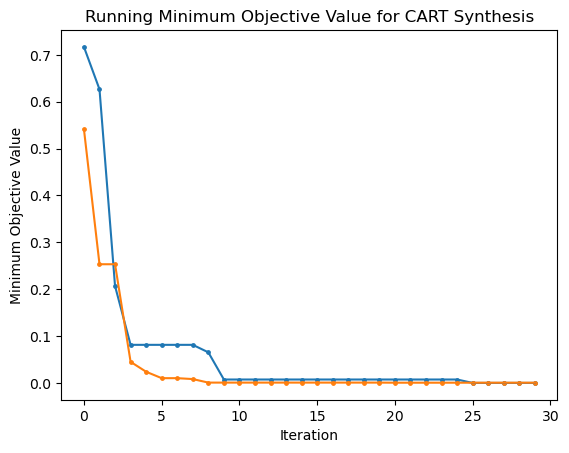

In [9]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -1.2576712034786402e-05,
 'params': {'mb_age_': 76.06657248361381,
  'mb_sex_': 96.95824286869994,
  'mb_state_': 15.5102758654989,
  'num_components_': 92.2226449348898}}

***

In [12]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_age_=int(best_params['params']['mb_age_']),
                                          mb_state_=int(best_params['params']['mb_state_']))

In [13]:
np.mean(pmse_ratios)

1.0587107281710597

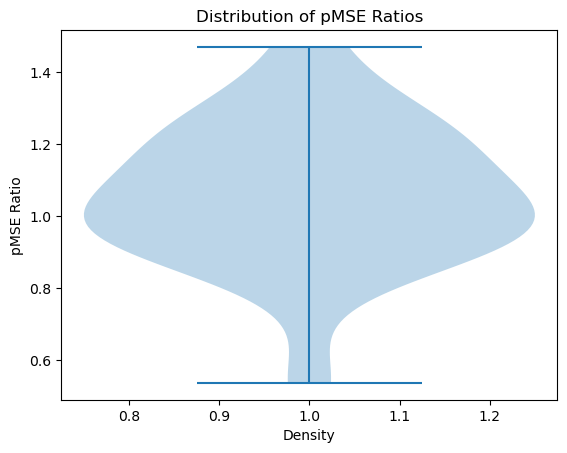

In [14]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

In [15]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

***

Now apply the attribute disclosure prevention algorithm.

Based on publicly available data from the World Health Organization, we use the total number of confirmed COVID-19 cases (9,583) and total number of deaths (152) in South Korea as of March 23, 2020 to calculate the prior probability $p(S_j = 1 | x_j^q, b) = 152/9583 \approx 0.016$ and $p(S_j = 0 | x_j^q, b) = 1 - 0.016 = 0.984$..984.

In [16]:
prior = 152/9583

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the correct disease status based on the synthetic data. This is a relatively large increase. For example, this means going from 0.016 under the prior to no more than 0.16 under the updated probability.

In [17]:
c = 10

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [18]:
deltas = np.linspace(0.001, 1, 5)

In [19]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['latitude', 'longitude'],
                                         categorical_vars=['sex', 'age'],
                                         sensitive_var='state',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 1 completed.


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.001


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.25075


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.5005


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 0.75025


C:\Users\Cameron\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 done.
Subset 1 done.
Subset 2 done.
Subset 3 done.
Completed for delta = 1.0
Full anonymization loop 2 completed.
Completed AD reduction.


In [20]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)

***

How many records did the attribute disclosure algorithm add, on average.

In [21]:
ad_sXs = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [22]:
num_records = train_data.shape[0]

In [23]:
num_records

6712

In [24]:
np.mean([Z.shape[0] - num_records for Z in ad_sXs])

433.9